In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('diabetes_prediction_dataset.csv')

df['smoking_history'] = df['smoking_history'].replace('ever', 'never')
# Fixing the 'ever' value to 'never' for consistency
df['smoking_history'] = df['smoking_history'].replace('not current', 'former')
# Fixing the 'not current' value to 'former' for consistency

df.replace('No Info', np.nan, inplace=True)
#Replacing 'No Info' with NaN for better handling of missing values


df = pd.get_dummies(df, columns=['smoking_history'], dummy_na=False)
#One-hot encoding the 'smoking_history' column

df = pd.get_dummies(df, columns=['gender'], drop_first=True)



# Assuming df is already loaded and cleaned
# Make sure your target column is named 'diabetes' or adjust accordingly

df['bmi_was_27_32'] = (df['bmi'] == 27.32).astype(int)

df['combined1']=df['HbA1c_level']**1.5 * df['blood_glucose_level'] 
#df['combined2']=df['bmi'] * df['age']**1.5 



In [3]:
print(df.isnull().sum())
# Check for missing values

age                        0
hypertension               0
heart_disease              0
bmi                        0
HbA1c_level                0
blood_glucose_level        0
diabetes                   0
smoking_history_current    0
smoking_history_former     0
smoking_history_never      0
gender_Male                0
gender_Other               0
bmi_was_27_32              0
combined1                  0
dtype: int64


Now will do a quick test to see whether a RandomForest or XGBoost Classifier gives the best result 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [08:36:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


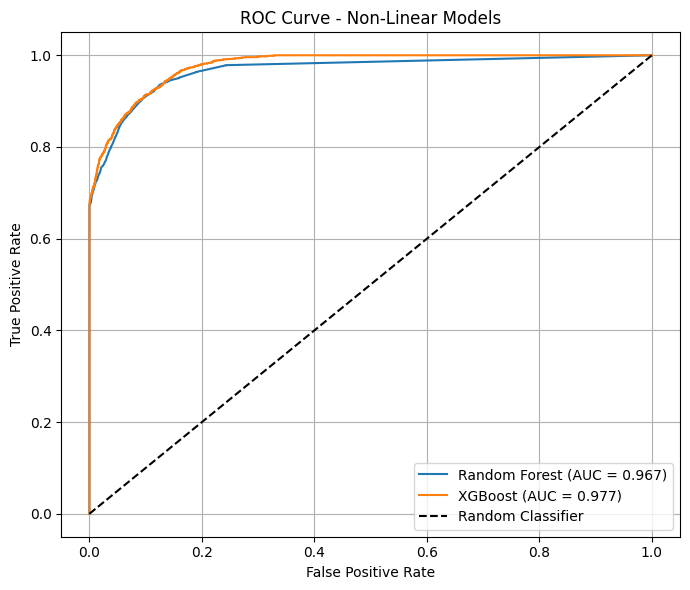

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

# Split the data
X = df.drop(columns='diabetes')
y = df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                             scale_pos_weight=y_train.value_counts()[0] / y_train.value_counts()[1],
                             random_state=42)
}

#  Train and evaluate
plt.figure(figsize=(7, 6))
for name, model in models.items():
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")
    
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Non-Linear Models')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The graph above suggests that XGBoost performs slightly better. We will now use grid search to pickout the best XGBoost hyperparameters

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, classification_report
import numpy as np

# Split the data
X = df.drop(columns='diabetes')
y = df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, (y_train.value_counts()[0] / y_train.value_counts()[1])]
}

# Set up GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid_xgb,
    scoring='average_precision', # Using average precision for imbalanced datasets
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search_xgb.fit(X_train, y_train)

# Best model
best_xgb = grid_search_xgb.best_estimator_
print("\nBest Parameters (XGBoost):", grid_search_xgb.best_params_)

# Predict probabilities
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Optimize threshold for best F1
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_xgb)
f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
best_f1_idx = np.argmax(f1)
best_thresh = thresholds[best_f1_idx]

# Predict using best threshold
y_pred_xgb = (y_proba_xgb >= best_thresh).astype(int)

# Report
print(f"\nXGBoost (F1-optimized) — Best Threshold: {best_thresh:.3f}")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:")
print(cm)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [08:36:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [08:36:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [08:36:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [08:36:27] WARNING: /Users/runner/work/xgboost/xgboost/src


Best Parameters (XGBoost): {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': np.float64(10.778563015312132), 'subsample': 1.0}

XGBoost (F1-optimized) — Best Threshold: 0.872
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       0.97      0.70      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.97      0.85      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Confusion Matrix:
[[18249    43]
 [  508  1200]]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [08:37:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Below, we will evalulate the model. Since we have a class imbalance, accuracy is not the best metric to use.
Instead, we compare recall over precision over different thresholds

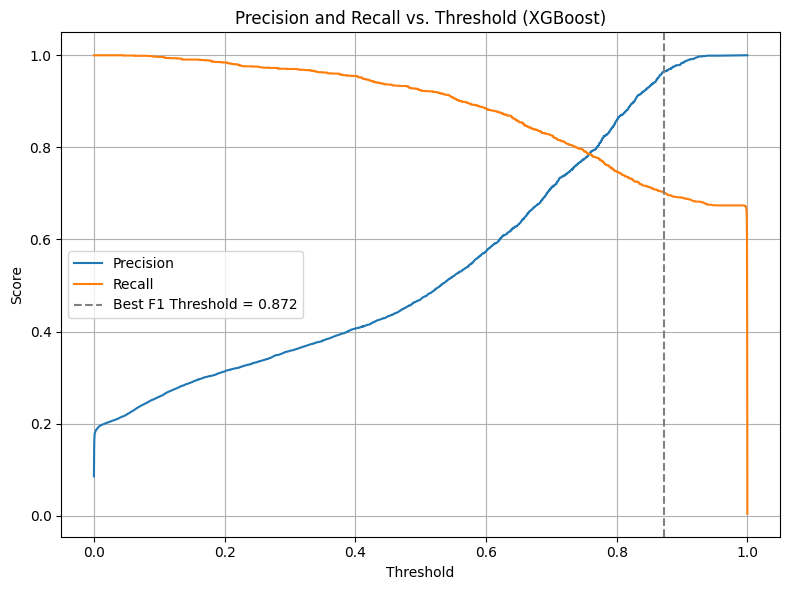

PR-AUC: 0.891


In [ ]:
# Plot Precision and Recall vs. Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(x=best_thresh, color='gray', linestyle='--', label=f'Best F1 Threshold = {best_thresh:.3f}') # F1 score is a metric that balances precision and recall
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold (XGBoost)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
#plt.plot(thresholds, f1[:-1], label='F1-score')


from sklearn.metrics import average_precision_score

# y_test = true labels
# y_proba = predicted probabilities for the positive class

pr_auc = average_precision_score(y_test, y_proba_xgb)
print(f"PR-AUC: {pr_auc:.3f}")

Depending on the applications, we may want to ensure that recall is as close to one as possible to catch almost all diabetes cases.
This would result in a low precision, meaning many false positives. But if further testing is expected, then false positives is not a serious as false negatives

It is near impossible to get a high recall and high precision score with such mechical data at one timestamp. 